In [1]:
from numpy import nan_to_num, array, empty_like, empty, vstack, concatenate, linspace, tile
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
import pickle
import gzip

In [2]:
%matplotlib inline

# Building extended covariance matrices for EEG-based BCI

## Loading EEG data

The data are freely available from [GitHub](https://github.com/sylvchev/dataset-ssvep-exoskeleton/). The stimulation onsets are indicated in `event_pos` and the stimulation of `event_type` are coded as follow: 33024, 33025, 33026 and 33027 denote respectively the resting class, the 13 Hz, the 21 Hz and the 17 Hz stimulations. 

In [3]:
with gzip.open('../data/record-[2012.07.06-19.06.14].pz', 'rb') as f:
    o = pickle.load(f, encoding='latin1')
raw_signal = o['raw_signal'].T
event_pos = o['event_pos'].reshape((o['event_pos'].shape[0]))
event_type = o['event_type'].reshape((o['event_type'].shape[0]))
sfreq = 256
classes = ['Resting', '13Hz', '21Hz', '17Hz']
channels = array(['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'])

In [4]:
labels = list()
for e in event_type:
    if e == 33024: labels.append('Resting')
    elif e == 33025: labels.append('13Hz')
    elif e == 33026: labels.append('21Hz')
    elif e == 33027: labels.append('17Hz')
labels = array(labels)

## Visualization of raw EEG data

Plot few seconds of signal from the `Oz` electrode.

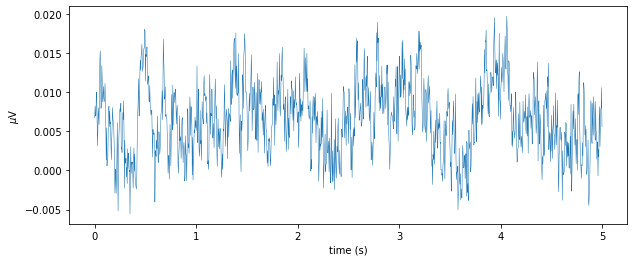

In [5]:
n_seconds = 5
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(10, 4))
plt.plot(time.T, raw_signal[channels == 'Oz', :n_seconds*sfreq].T, lw=0.5)
plt.xlabel("time (s)")
_ = plt.ylabel(r"$\mu$V")

And a fewer seconds of all electrodes:

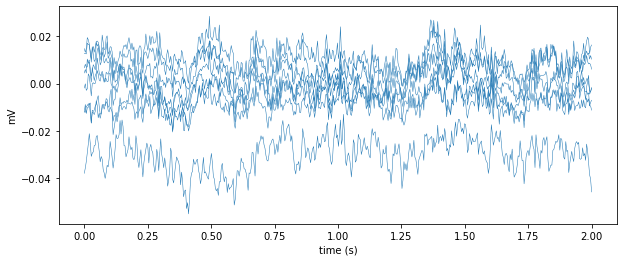

In [6]:
n_seconds = 2
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(10, 4))
plt.plot(time.T, raw_signal[:, :n_seconds*sfreq].T, color='C0', lw=0.5)
plt.xlabel("time (s)")
_ = plt.ylabel(r"mV")

## Extended signals for spatial covariance

In the approach proposed by [Congedo, 2013], the SSVEP signal $X \in \mathbb{R}^{C \times N}$ is extended to include the filtered signal for each stimulation frequency. The extended signal $X_{\mathrm{ext}}$ is defined as:

\begin{equation}
X_{\mathrm{ext}} = 	
\begin{bmatrix}
 X_{\text{freq}_1}\\ 
\vdots \\
X_{\text{freq}_{F}} \\
\end{bmatrix}
\in \mathbb{R}^{FC \times N} \ ,
\end{equation}
Where $C$, $N$, and $F$ are respectively the number of channels, number of samples, anf number of stimululation frequency.

Thus we need to define a fonction for filtering the signal with a $5^{\mathrm{th}}$ order bandpass Butterworth filter around the stimulation frequency.

In [7]:
def butter_bandpass(signal, lowcut, highcut, fs=256, order=4, filttype='forward-backward'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    if filttype == 'forward':
        filtered = lfilter(b, a, signal, axis=-1)
    elif filttype == 'forward-backward':
        filtered = filtfilt(b, a, signal, axis=-1)
    else:
        raise ValueError("Unknown filttype:", filttype)    
    return filtered

In [8]:
from mne import create_info
from mne.io import Raw, RawArray
info = create_info(
    ch_names=['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'],
    ch_types=['eeg'] * 8,
    sfreq=sfreq)

raw_ext = RawArray(raw_signal, info)

Creating RawArray with float64 data, n_channels=8, n_times=57024
    Range : 0 ... 57023 =      0.000 ...   222.746 secs
Ready.


In [9]:
def _bandpass_filter(signal, lowcut, highcut):
    """ Bandpass filter using MNE """
    return signal.copy().filter(l_freq=lowcut, h_freq=highcut,
                                method="iir").get_data()

Now, we can construct the extended signal $E_{\mathrm{ext}}$.

In [10]:
import numpy as np
frequencies = [13., 17., 21.]
freq_band = 0.1    
ext_signal = np.vstack([butter_bandpass(raw_ext.get_data(),
                                         lowcut=f-freq_band,
                                         highcut=f+freq_band,
                                         )
                        for f in frequencies])
ext_signal = ext_signal[1:,:]

The trial start is indicated by the code 32779, best option is to wait 2 seconds after cue onset (see [this article](http://authors.elsevier.com/sd/article/S0925231216000540) for detailled analysis). To ensure the robustness of this approach, spatial covariance matrices estimated from 3 seconds of EEG signals offers very good results.

In [11]:
ext_trials = list()
for e, t in zip(event_type, event_pos):
    if e == 32779: # start of a trial
        start = t + 2*sfreq
        stop = t + 5*sfreq
        ext_trials.append(ext_signal[:, start:stop])
ext_trials = array(ext_trials)
ext_trials = ext_trials - tile(ext_trials.mean(axis=2).reshape(ext_trials.shape[0], 
                            ext_trials.shape[1], 1), (1, 1, ext_trials.shape[2]))

## Visualization of filtered signal

Plotting the `Oz` signal filtered at the different frequencies:

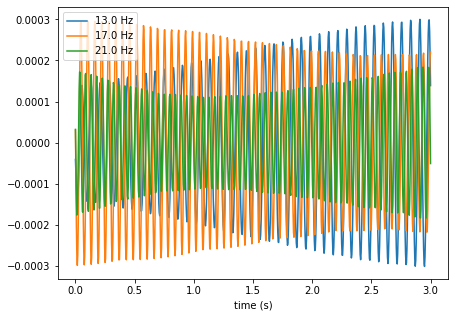

In [12]:
n_seconds = 3
time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
plt.figure(figsize=(7, 5))
plt.plot(time.T, ext_trials[2, 0, :].T, label=str(frequencies[0])+' Hz')
plt.plot(time.T, ext_trials[2, 8, :].T, label=str(frequencies[1])+' Hz')
plt.plot(time.T, ext_trials[2, 16, :].T, label=str(frequencies[2])+' Hz')
plt.xlabel("time (s)")
_ = plt.legend(loc='upper left')

As it can be seen on this example, the subject is watching the 17Hz stimulation and the EEG activity is showing an increase activity in this frequency band as the focus is more and more focus on the blinking stimulation.

## Spatial covariance estimation

The covariance matrices will be estimated using the Ledoit-Wolf shrinkage estimator.

In [13]:
from pyriemann.estimation import Covariances

cov_ext_trials = Covariances(estimator='lwf').transform(ext_trials)

## Visualisation of the covariance matrices

The matrix plot shows the block structure resulting from the extended signal. Most of the signal energy is concentrated in the 13 Hz frequency band.

In [14]:
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.distance import distance_riemann

labels = list()
for e in event_type:
    if e == 33024: labels.append('Resting')
    elif e == 33025: labels.append('13Hz')
    elif e == 33026: labels.append('21Hz')
    elif e == 33027: labels.append('17Hz')
labels = array(labels)



y_train = labels[::2] # take even indexes
y_test = labels[1::2] # take odd indexes

cov_train = cov_ext_trials[::2]
cov_test = cov_ext_trials[1::2]


# with gzip.open('./data/record-[2014.03.10-19.47.49].pz', 'rb') as f:
#     o = pickle.load(f, encoding='latin1')
# cov_train = o['cov_train']
# cov_test = o['cov_test']
# y_train = o['y_train']
# y_test = o['y_test']
# classes = o['classes']
cov_centers = empty((len(classes), 23, 23))

for i, l in enumerate(classes):
    cov_centers[i, :, :] = mean_riemann(cov_train[y_train == l, :, :])

accuracy = list()
for sample, labels in zip(cov_test, y_test):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(len(classes))]
    if classes[array(dist).argmin()] == labels:
        accuracy.append(1)
    else: accuracy.append(0)
test_accuracy = 100.*array(accuracy).sum()/len(y_test)
            
print ('Evaluation accuracy on test set is %.2f%%' % test_accuracy)


Evaluation accuracy on test set is 56.25%


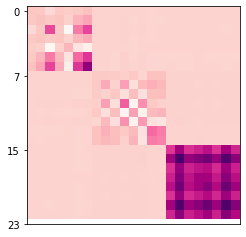

In [15]:
plt.figure()
plt.imshow(cov_ext_trials[0, :, :], 
           cmap=plt.get_cmap('RdPu'), 
           interpolation='nearest')
plt.xticks([])
_ = plt.yticks([0, 7, 15, 23])

The next plot shows an example of the first covariance matrix observed for each class:

In [16]:
plt.figure(figsize=(7, 7))
for i, l in enumerate(classes):
    plt.subplot(2, 2, i+1)
    plt.imshow(cov_ext_trials[labels == l, :, :][0, :, :], 
               cmap=plt.get_cmap('RdPu'), 
               interpolation='nearest')
    plt.xticks([])
    plt.yticks([0, 7, 15, 23])
    _ = plt.title(l)

IndexError: index 0 is out of bounds for axis 0 with size 0

It appears clearly that each class yields a different structure of the covariance matrix. Each stimulation (13, 17 and 21 Hz) generating higher covariance values for EEG signal filtered at the proper bandwith and no activation at all for the other bandwith. The resting state, where the subject focus on the center of the display and far from all blinking stimulations, shows an activity with higher correlation in the 13Hz frequency and lower but still visible activity in the other bandwith. 

## SSVEP Covariances

To process EEG data from SSVEP experiment, it is possible to define a new Covariance class, derived from pyriemann, to obtain the same results. First, we need a more complete function to filter the data :

In [ ]:
def _butter_bandpass(signal, lowcut, highcut, fs, order=4, filttype='forward-backward'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    if filttype == 'forward':
        filtered = lfilter(b, a, signal, axis=-1)
    elif filttype == 'forward-backward':
        filtered = filtfilt(b, a, signal, axis=-1)
    else:
        raise ValueError("Unknown filttype:", filttype)    
    return filtered

We could define the `SSVEPCovariance` class such as:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from pyriemann.utils.covariance import covariances

class SSVEPCovariances(BaseEstimator, TransformerMixin):
    """Estimate special form covariance matrix for SSVEP.
    Estimation of special form covariance matrix dedicated to SSVEP processing.
    A frequency banks is applied on the signal :math:`\mathbf{X}_i`
    and a super trial is build using the concatenation of :math:`f=1, \ldots, F` frequency bands :
    .. math::
        \mathbf{\\tilde{X}}_i =  \left[
                                 \\begin{array}{c}
                                 \mathbf{X}_{i,1} \\\\
                                 \vdots \\\\
                                 \mathbf{X}_{i,F} \\\\
                                 \end{array}
                                 \\right]
    This super trial :math:`\mathbf{\\tilde{X}}_i` will be used for covariance
    estimation.
    This allows to take into account the frequency structure of the signal, as
    described in [1,2,3].
    Parameters
    ----------
    estimator : string (default: 'scm')
        covariance matrix estimator. For regularization consider 'lwf' or 'oas'
        For a complete list of estimator, see `utils.covariance`.
    freq_targets : list of float
        list of n_frequency target frequencies.
    freq_band : float
        half-width of the frequency bands.
    fs : float
        sampling frequency of the signal.
    order : integer (default: 4)
        order of the Butterworth filter.
    filttype : string (default: 'forward')
        type of the Butterworth filter: 'forward' or 
        'forward-backward' for a bilateral filtering.
    See Also
    --------
    Covariances
    CospCovariances
    References
    ----------
    [1] M. Congedo, A. Barachant, A. Andreev ,"A New generation of
    Brain-Computer Interface Based on Riemannian Geometry", arXiv: 1310.8115.
    2013.
    [2] TODO, NeuroComputing2016
    [3] TODO, NeuroInformatics2020
    """

    def __init__(self, estimator='scm', freq_targets=[13, 17, 21], freq_band=0.1, 
                 fs=256, order=4, filttype='forward-backward'):
        """Init."""
        self.estimator = estimator
        self.freq_targets = freq_targets
        self.freq_band = freq_band
        self.fs = fs
        self.order = order
        self.filttype = filttype

    def fit(self, X, y):
        """Fit.
        Do nothing. For compatibility purpose.
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_channels, n_samples)
            ndarray of trials.
        y : ndarray shape (n_trials,)
            labels corresponding to each trial.
        Returns
        -------
        self : SSVEPCovariances instance
            The SSVEPCovariances instance.
        """

        return self

    def transform(self, X):
        """Estimate SSVEP form covariance matrices.
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_channels, n_samples)
            ndarray of raw trials.
        Returns
        -------
        covmats : ndarray, shape (n_trials, n_channel*n_frequency, n_channel*n_frequency)
            ndarray of SSVEP covariance matrices for each trials.
        """
        
        
        X = np.array(X)
        covmats = covariances(X, estimator=self.estimator)
        return covmats

This new estimator could work directly on EEG trials. We need to extract the trials from the raw signal:

In [ ]:
trials = list()
for e, t in zip(event_type, event_pos):
    if e == 32779: # start of a trial
        start = t + 2*sfreq
        stop = t + 5*sfreq
        trials.append(raw_signal[:, start:stop])
trials = array(trials)
trials = trials - tile(trials.mean(axis=2).reshape(trials.shape[0], 
                            trials.shape[1], 1), (1, 1, trials.shape[2]))

Computing the extended covariance matrices for SSVEP is thus simple as:

In [ ]:
from mne import create_info
from mne.io import Raw, RawArray
import numpy as np

filtered_trials = []
for trial in trials:
    info = create_info(
        ch_names=['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'],
        ch_types=['eeg'] * 8,
        sfreq=sfreq)

    raw_ext = RawArray(trial, info)

    frequencies = [13., 17., 21.]
    freq_band = 0.1    
    ext_signal = np.vstack([_bandpass_filter(raw_ext,
                                            lowcut=f-freq_band,
                                            highcut=f+freq_band,
                                            )
                            for f in frequencies])
    #ext_signal = ext_signal[1:,:]
    filtered_trials.append(ext_signal)

    

In [ ]:
sscov_trials = SSVEPCovariances(estimator='lwf', freq_targets=[13, 17, 21],
                              filttype='forward-backward').transform(filtered_trials)

We could verify that the first covariance matrices of each class are correct:

In [ ]:
plt.figure(figsize=(7, 7))
for i, l in enumerate(classes):
    plt.subplot(2, 2, i+1)
    plt.imshow(sscov_trials[labels == l, :, :][0, :, :], 
               cmap=plt.get_cmap('RdPu'), 
               interpolation='nearest')
    plt.xticks([])
    plt.yticks([0, 7, 15, 23])
    _ = plt.title(l)

In [ ]:
from pyriemann.utils.distance import distance_riemann

In [ ]:

from __future__ import print_function
from numpy import nan_to_num, array, empty_like, empty, vstack, concatenate, linspace, tile
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
import pickle
import gzip

In [ ]:
accuracy = list()
for sample, true_label in zip(sscov_trials, y_test):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(len(classes))]
    if classes[array(dist).argmin()] == true_label:
        accuracy.append(1)
    else: accuracy.append(0)
test_accuracy = 100.*array(accuracy).sum()/len(y_test)
            
print ('Evaluation accuracy on test set is %.2f%%' % test_accuracy)

In [ ]:
# generic import
import os
import numpy as np
import matplotlib.pyplot as plt

# mne import
from mne import get_config, set_config, find_events, create_info, Epochs
from mne.datasets.utils import _get_path
from mne.utils import _fetch_file, _url_to_local_path
from mne.io import Raw, RawArray

# pyriemann import
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_riemann
from pyriemann.classification import MDM

# scikit-learn import
from sklearn.model_selection import cross_val_score, RepeatedKFold

# Butter filter
from scipy.signal import filtfilt, butter

In [ ]:
cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=42)
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
scores = cross_val_score(mdm, sscov_trials, labels, cv=cv, n_jobs=1)
print("MDM accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))

In [ ]:
from mne import Epochs, find_events, read_events, pick_types, create_info
# Get the dataset with the data to reproduce the real time acquisition of brain data - Pass the data for a RAW variable
raw_fname = '../data/record-[2014.03.10-19.17.37]_raw.fif'
raw = Raw(raw_fname, preload=True, verbose=False)

# replace baselining with high-pass
raw.filter(2, None, method='iir') 

# find events
event_fname = '../data/record-[2014.03.10-19.17.37]-eve.fif'
events = read_events(event_fname)
event_id = {'13 Hz': 2, '17 Hz': 4, '21 Hz': 3, 'resting-state': 1}

In [ ]:
## Data Filtering for each frequency and new raw object creation

def _bandpass_filter(signal, lowcut, highcut):
    """ Bandpass filter using MNE """
    return signal.copy().filter(l_freq=lowcut, h_freq=highcut,
                                method="iir").get_data()

# We stack the filtered signals to build an extended signal

frequencies = [13., 17., 21.]
freq_band = 0.1
ext_signal = np.vstack([_bandpass_filter(raw,
                                         lowcut=f-freq_band,
                                         highcut=f+freq_band)
                        for f in frequencies])

###############################################################################
# Creating an MNE Raw object from the extended signal
sfreq = int(raw.info['sfreq'])

info = create_info(
    ch_names=sum(list(map(lambda s: [ch+s for ch in raw.ch_names],
                          ["-13Hz", "-17Hz", "-21Hz"])), []),
    ch_types=['eeg'] * 24,
    sfreq=sfreq)

raw_ext = RawArray(ext_signal, info)

In [ ]:
tmin, tmax = -0., 2
epochs = Epochs(raw_ext, events, event_id, tmin, tmax, baseline=None)

# Extract data from Epochs object in (Trial, Channel, Sample) format
epochs_data = epochs.get_data()

In [ ]:
cov = Covariances().transform(epochs_data)

In [ ]:
labels = [1, 1, 1, 3, 4, 2, 3, 1, 2, 4, 2, 3, 1, 4, 3, 4, 2, 1, 4, 2, 3, 4, 1, 2, 3, 2, 4, 1, 3, 4, 3, 2]

In [ ]:
scores = cross_val_score(mdm, cov, labels, cv=cv, n_jobs=1)
print("MDM accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))